In [1]:
import sys
!{sys.executable} -m pip install pillow matplotlib rasterio scikit-image scikit-learn

     |████████████████████████████████| 19.3 MB 450 kB/s 


In [2]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image # remove if needed 
from tqdm.notebook import tqdm_notebook
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from skimage.segmentation import slic
from skimage.io import imread

In [4]:
from google.colab import drive
drive._mount('/content/drive') #change in function of where the data are stored 

Mounted at /content/drive


# Download the images and prepare them for the study

Create the list of pathways

In [5]:
pathway = ["08_December_2016","27_May_2017","06_December_2017","19_June_2018",
           "31_December_2018","26_June_2019","06_December_2019","23_June_2020",
           "11_Jan_2021","13_June_2021","07_December_2021"]

Download the 4 bands (RGB+NIR) and labels for each image


In [6]:
#change in function of where the data are stored 
band2 = [rasterio.open("/content/drive/MyDrive/IPEO/" + path + "_images/band2.jpg").read(1) for path in pathway]
band3 = [rasterio.open("/content/drive/MyDrive/IPEO/" + path + "_images/band3.jpg").read(1) for path in pathway]
band4 = [rasterio.open("/content/drive/MyDrive/IPEO/" + path + "_images/band4.jpg").read(1) for path in pathway]
band11 = [rasterio.open("/content/drive/MyDrive/IPEO/" + path + "_images/band11.jpg").read(1) for path in pathway]
labels = [rasterio.open("/content/drive/MyDrive/IPEO/" + path + "_images/label.png").read(1) for path in pathway]

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [7]:
# Conversion of the bands and labels in numpy arrays
band2 = np.array(band2)
band3 = np.array(band3)
band4 = np.array(band4)
band11 = np.array(band11)
labels = np.array(labels)

In [8]:
# Convert from int8 to float32
band2 = band2.astype('float32')
band3 = band3.astype('float32')
band4 = band4.astype('float32')
band11 = band11.astype('float32')

Calculate the NDSI value

In [9]:
modifier_NDSI = 0.0001*np.ones(band2.shape) # Coefficient to avoid division by zero
NDSI = (band3-band11)/(band3+band11+modifier_NDSI)

Compute the matrix of features

In [10]:
X = np.array([band2,band3,band4,band11,NDSI])
X = np.transpose(X,(1,0,2,3)) # Transpose to the format image*band*width*height

In [11]:
# Crop the image to have a size divisible by 12
X = X[:,:,:3024,:2496]
labels_crop = labels[:,:3024,:2496]
labels_crop.shape

(11, 3024, 2496)

Define some functions usefull to convert pixels to patches

In [12]:
def pixels_to_patches_labels(my_array, patch_size):
  n,a,b = my_array.shape[0],my_array.shape[1],my_array.shape[2]
  x = a//patch_size
  y = b//patch_size
  my_array_per_patch = np.zeros((n,x,y))
  for image in range(n):
    for k in range(x):
      for j in range(y):
        mean = my_array[image,k*patch_size:(k+1)*patch_size,j*patch_size:(j+1)*patch_size].mean()
        if mean>=0.5 :
          my_array_per_patch[image,k,j] = 1
  return my_array_per_patch   

In [13]:
def compute_histogram(patch, bins, patch_size):
  hist = []
  patch_normalized = (patch-patch.min())/(patch.max()-patch.min())
  for k in range(bins):
    T = np.ones(patch_normalized.shape)
    hist.append(T[patch_normalized<=(k+1)/bins].sum())
  for k in range(bins-1,0,-1):
    hist[k] -= hist[k-1]  
  return np.array(hist)/patch_size**2

def compute_entropy(hist):
  return -np.nansum(hist*np.log(hist))

def compute_features_per_patch(patch, bins, patch_size):
  features = np.zeros((3+bins)) #mean, std, entropy and histogram with bins
  features[0] = patch.mean()
  features[1] = patch.std()
  hist = compute_histogram(patch,bins,patch_size)
  features[3:3+bins] = hist
  features[2] = compute_entropy(hist)
  return features

def pixels_to_patches_features(my_array, patch_size, bins=50):
  n,m,a,b = my_array.shape[0],my_array.shape[1],my_array.shape[2],my_array.shape[3]
  x = a//patch_size
  y = b//patch_size
  my_array_per_patch = np.zeros((n,(3+bins)*m,x,y))
  for image in tqdm_notebook(range(n)):
    for band in tqdm_notebook(range(m)):
      for k in range(x):
        for j in range(y):
          my_array_per_patch[image,band*(3+bins):(band+1)*(3+bins),k,j] = \
          compute_features_per_patch(my_array[image,band,k*patch_size:(k+1)*patch_size,j*patch_size:(j+1)*patch_size], bins, patch_size)
  return my_array_per_patch 

Make patches from original images and computes features and label per patch

In [14]:
X = pixels_to_patches_features(X, 12, bins=10) #10 min to run it with bins=10, ~28 min with bins=50
X.shape

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

(11, 65, 252, 208)

In [15]:
labels_patches = pixels_to_patches_labels(labels_crop, 12)

# Split in train, validation and test sets

In [16]:
def flatten_X(X,k):
  X = X[k:k+1]
  X = np.transpose(X,(2,3,0,1))
  X = np.resize(X,(1*252*208,65)) # change in function of the bin 
  return X

def flatten_y(y,k):  
  y = y[k:k+1]
  y = y.flatten()
  return y 

In [17]:
X_flatten = [flatten_X(X,k) for k in range(11)]  
y_flatten = [flatten_y(labels_patches,k) for k in range(11)]

X_train = np.concatenate((X_flatten[3:6]+X_flatten[7:10]),axis=0)
X_valid = np.concatenate(X_flatten[0:2],axis=0)
X_test = np.concatenate((X_flatten[2:3]+X_flatten[6:7]+X_flatten[10:11]),axis=0)
y_train = np.concatenate((y_flatten[3:6]+y_flatten[7:10]),axis=0)
y_valid = np.concatenate(y_flatten[0:2],axis=0)
y_test = np.concatenate((y_flatten[2:3]+y_flatten[6:7]+y_flatten[10:11]),axis=0)

print(X_train.shape,y_train.shape) 

(314496, 65) (314496,)


# Create and train different models using patches

Define function usefull for the study

In [18]:
def plot_confusion_matrix(conf_matrix):
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='x-large')
    
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Ground Truth', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()    

## Random Forest

Search for the best parameters

In [ ]:
n_estimators_values = [20, 50, 100, 200]
max_depth_values = [5, 10, 20, None]

for n in tqdm_notebook(n_estimators_values):
  for d in tqdm_notebook(max_depth_values):
    classifier_rf_patch = RandomForestClassifier(random_state = 10, n_estimators=n, max_depth=d)
    classifier_rf_patch.fit(X_train, y_train)
    prediction = classifier_rf_patch.predict(X_valid)
    accuracy = accuracy_score(y_valid, prediction)
    if d == None:
      print("Accuracy of %f with %d estimators without max depth" % (accuracy,n))
    else:  
      print("Accuracy of %f with %d estimators and max depth of %d" % (accuracy,n,d))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Accuracy of 0.936556 with 20 estimators and max depth of 5
Accuracy of 0.950836 with 20 estimators and max depth of 10
Accuracy of 0.950588 with 20 estimators and max depth of 20
Accuracy of 0.951227 with 20 estimators without max depth


  0%|          | 0/4 [00:00<?, ?it/s]

Accuracy of 0.936279 with 50 estimators and max depth of 5
Accuracy of 0.951341 with 50 estimators and max depth of 10
Accuracy of 0.951542 with 50 estimators and max depth of 20
Accuracy of 0.951675 with 50 estimators without max depth


  0%|          | 0/4 [00:00<?, ?it/s]

Accuracy of 0.936975 with 100 estimators and max depth of 5
Accuracy of 0.951542 with 100 estimators and max depth of 10
Accuracy of 0.951532 with 100 estimators and max depth of 20
Accuracy of 0.951894 with 100 estimators without max depth


  0%|          | 0/4 [00:00<?, ?it/s]

Accuracy of 0.936126 with 200 estimators and max depth of 5
Accuracy of 0.951713 with 200 estimators and max depth of 10
Accuracy of 0.951761 with 200 estimators and max depth of 20
Accuracy of 0.951933 with 200 estimators without max depth


Train the Random Forest with the best parameters

In [19]:
classifier_rf_patch = RandomForestClassifier(random_state=10, n_estimators=200, max_depth = None)
classifier_rf_patch.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=10)

In [20]:
pred_valid_rf_patch = classifier_rf_patch.predict(X_valid)
pred_test_rf_patch = classifier_rf_patch.predict(X_test)

Plot the confusion matrix of Random Forest on patches on the validation set

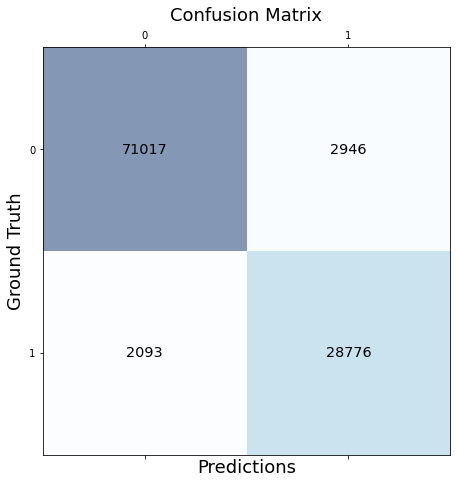

accuracy score  0.951932615995116
f1 score  0.9194932178747744


In [22]:
conf_matrix = confusion_matrix(y_valid, pred_valid_rf_patch)
plot_confusion_matrix(conf_matrix)
print("accuracy score ",  accuracy_score(y_valid, pred_valid_rf_patch))
print("f1 score ", f1_score(y_valid, pred_valid_rf_patch))

## KNN
Here the size of our matrix X is really important (314496, 65), using directly on it the KNN will be very long to do any prediction. To save some calculation power it is important to reduce the number of features of our input. To do so, we use the PCA algorithm and consider the new number of features as a new hyperparameter.

Search for the best parameters

In [ ]:
reduction_values = [5,10,15] 
k_values = np.arange(1,42,4)
for r in tqdm_notebook(reduction_values):
  accuracies = np.zeros(k_values.shape)
  pca_instance = PCA(r, random_state = 10)
  X_train_reduced = pca_instance.fit_transform(X_train)
  X_valid_reduced = pca_instance.fit_transform(X_valid)
  for ind,k in tqdm_notebook(enumerate(k_values)):
      classifier = KNeighborsClassifier(n_neighbors=k)
      classifier.fit(X_train_reduced, y_train)
      prediction = classifier.predict(X_valid_reduced)
      accuracies[ind] = accuracy_score(y_valid, prediction)
    
  print("Best accuracy of %f with reduction to %d features and K=%d" % (accuracies.max(),r,np.argmax(accuracies)))   

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Best accuracy of 0.908797 with reduction to 5 features and K=9


0it [00:00, ?it/s]

Best accuracy of 0.909112 with reduction to 10 features and K=9


0it [00:00, ?it/s]

Best accuracy of 0.909112 with reduction to 15 features and K=9


We obtain here the same accuracy for both 10 and 15 features (with 9 neighbors), to optimise the speed of our algorithm we will take 10 features for the following study.

Train the KNN with the best hyperparameters

In [23]:
pca_instance = PCA(10, random_state = 10)
X_train_reduced = pca_instance.fit_transform(X_train)
X_valid_reduced = pca_instance.fit_transform(X_valid)
X_test_reduced = pca_instance.fit_transform(X_test)

In [24]:
classifier_knn_patch = KNeighborsClassifier(n_neighbors=9)
classifier_knn_patch.fit(X_train_reduced, y_train)

KNeighborsClassifier(n_neighbors=9)

In [25]:
pred_valid_knn_patch = classifier_knn_patch.predict(X_valid_reduced)
pred_test_knn_patch = classifier_knn_patch.predict(X_test_reduced)

Plot the confusion matrix of K Nearest Neighbors on patches on the validation set

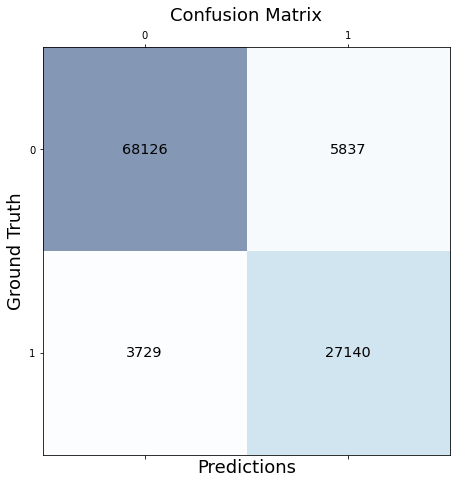

accuracy score  0.9087492368742369
f1 score  0.8501707233029476


In [26]:
conf_matrix = confusion_matrix(y_valid, pred_valid_knn_patch)
plot_confusion_matrix(conf_matrix)
print("accuracy score ",accuracy_score(y_valid, pred_valid_knn_patch))
print("f1 score ",f1_score(y_valid, pred_valid_knn_patch))

# Then using SLIC regions

## Computation of SLIC regions and features

In [ ]:
X = np.array([band2,band3,band4,band11,NDSI])
X = np.transpose(X,(1,2,3,0)) # Transpose to the format image*width*height*band

In [ ]:
def convert_to_shape_pixels_by_bands(data):
    num_dimensions = len(data.shape)
    assert(num_dimensions == 2 or num_dimensions == 3)
    if num_dimensions == 3:
        num_bands = data.shape[2]
        return data.reshape((-1, num_bands))
    else:
        return data

def compute_average_feature(data):
    # If needed convert data to the shape (num_pixels x num_bands)
    data_2d = convert_to_shape_pixels_by_bands(data)
    # Get the number of bands
    num_bands = data_2d.shape[1]
    avg_features = np.zeros(num_bands)
    for b in range(num_bands):
        # Compute the average value of each band (use the function np.mean)
        avg_features[b] = np.mean(data_2d[:, b])
    return avg_features

def compute_standard_deviation_feature(data):
    # If needed convert data to the shape (num_pixels x num_bands)
    data_2d = convert_to_shape_pixels_by_bands(data)
    # Compute the standard deviation feature (using the numpy function np.std)
    #       as in the function compute_average_feature iterate over the bands
    #       and compute one value for each band
    num_bands = data_2d.shape[1]
    avg_features = np.zeros(num_bands)
    for b in range(num_bands):
        avg_features[b] = np.std(data_2d[:, b])
    return avg_features

def compute_histogram_feature(data, num_bins=10):
    # If needed convert data to the shape (num_pixels x num_bands)
    data_2d = convert_to_shape_pixels_by_bands(data)
    num_bands = data_2d.shape[1]
    hist_features = np.zeros((num_bands, num_bins)).astype(np.float32)
    for b in range(num_bands):
        # Compute the histogram for each band 
        #       use the function np.histogram(array, bins=num_bins)
        hist, boundaries = np.histogram(data_2d[:, b], bins=num_bins)
        hist_features[b, :] = hist
    # Return a 1D array containing all the values
    return hist_features.flatten()

def compute_entropy_slic(hist):
  return -np.nansum(hist*np.log(hist))

def compute_image_features_from_regions(image, segmentation_map):
    num_regions = len(np.unique(segmentation_map))
    all_features = []
    for id_region in range(num_regions):
        # Obtain pixel values of each regions, with shape (num_pixels x num_bands)
        pixel_values = image[segmentation_map==id_region]
        # Compute the average, standard deviation and histogram features
        #       and concatenated them unsing the function (np.concatenate)
        avg = compute_average_feature(pixel_values)
        features = compute_standard_deviation_feature(pixel_values)
        hist_features = compute_histogram_feature(pixel_values)
        entropy_features = compute_entropy_slic(hist_features)
        features = np.concatenate([avg, features, hist_features, [entropy_features]])
        # Add concatenated features to the variable all_features
        all_features.append(features)
    # convert list to numpy array of shape: (num_regions x num_bands)
    return np.array(all_features).astype(np.float32)

## Create segmentation maps, labels and splits

In [ ]:
segmented_images = []
for image in tqdm_notebook(range(X.shape[0])):
  slic_im = slic(X[image], n_segments = 1000)
  segmented_images.append(slic_im)


  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
#get features
X_slic = []
for image in tqdm_notebook(range(X.shape[0])):
  X_slic_image = compute_image_features_from_regions(X[image], segmented_images[image])
  X_slic.append(X_slic_image)

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in multiply


In [ ]:
def get_label_per_region(segmented_image, label_map):
    """
    Returns a 1D numpy array that contains the label for each region, shape: (num_regions)
            For each region, we obtain the label that has the largest intersection with it
    """
    num_regions = len(np.unique(segmented_image))
    num_labels = len(np.unique(label_map))
    region_labels = []
    for region_id in range(num_regions):
        mask_region = segmented_image == region_id
        
        intersection_per_label = []
        for label_id in range(num_labels):
            mask_label = label_map == label_id
            # Compute intersection of each region with each label
            intersection = np.sum(mask_region * mask_label)
            intersection_per_label.append(intersection)
            
        intersection_per_label = np.array(intersection_per_label)
        # Obtain the index of the label with largest intersection
        selected_label = np.argmax(intersection_per_label)
        region_labels.append(selected_label)
    
    return np.array(region_labels).astype(np.uint32)

In [ ]:
train_indices = [3,4,5,7,8,9]
test_indices = [2,6,10]
val_indices = [0,1]
train_features_slic =[]
train_labels_slic = []
for image in tqdm_notebook(train_indices):
  train_features = X_slic[image]
  train_labels = get_label_per_region(segmented_images[image], labels[image])
  train_features_slic.append(train_features)
  train_labels_slic.append(train_labels)

train_features_slic = np.concatenate(train_features_slic)
train_labels_slic = np.concatenate(train_labels_slic)

test_features_slic = []
test_labels_slic = []

for image in tqdm_notebook(test_indices):
  test_features = X_slic[image]
  test_labels = get_label_per_region(segmented_images[image], labels[image])
  test_features_slic.append(test_features)
  test_labels_slic.append(test_labels)

test_features_slic = np.concatenate(test_features_slic)
test_labels_slic = np.concatenate(test_labels_slic)

val_features_slic =[]
val_labels_slic = []
for image in tqdm_notebook(val_indices):
  val_features = X_slic[image]
  val_labels = get_label_per_region(segmented_images[image], labels[image])
  val_features_slic.append(val_features)
  val_labels_slic.append(val_labels)

val_features_slic = np.concatenate(val_features_slic)
val_labels_slic = np.concatenate(val_labels_slic)



  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

## Random forest with SLIC regions

In [ ]:
# Normalize features
mean_train_slic = np.mean(train_features_slic, axis = 0)
std_train_slic = np.std(train_features_slic, axis = 0)
norm_train_features_slic = (train_features_slic - mean_train_slic)/std_train_slic

#normalize with same values of train set for test and val
norm_test_features_slic = (test_features_slic - mean_train_slic)/std_train_slic 
norm_val_features_slic = (val_features_slic - mean_train_slic)/std_train_slic

In [ ]:
#search for best hyperparameters
n_estimators_values = [20, 50, 100, 200]
max_depth_values = [5, 10, 20, None]

for n in tqdm_notebook(n_estimators_values):
  for d in tqdm_notebook(max_depth_values):
    classifier_rf_region = RandomForestClassifier(random_state = 10, n_estimators=n, max_depth=d)
    classifier_rf_region.fit(norm_train_features_slic, train_labels_slic)
    prediction = classifier_rf_region.predict(norm_val_features_slic)
    accuracy = accuracy_score(val_labels_slic, prediction)
    if d == None:
      print("Accuracy of %f with %d estimators without max depth" % (accuracy,n))
    else:  
      print("Accuracy of %f with %d estimators and max depth of %d" % (accuracy,n,d))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Accuracy of 0.959391 with 20 estimators and max depth of 5
Accuracy of 0.956853 with 20 estimators and max depth of 10
Accuracy of 0.956853 with 20 estimators and max depth of 20
Accuracy of 0.956853 with 20 estimators without max depth


  0%|          | 0/4 [00:00<?, ?it/s]

Accuracy of 0.961929 with 50 estimators and max depth of 5
Accuracy of 0.959391 with 50 estimators and max depth of 10
Accuracy of 0.959391 with 50 estimators and max depth of 20
Accuracy of 0.959391 with 50 estimators without max depth


  0%|          | 0/4 [00:00<?, ?it/s]

Accuracy of 0.959391 with 100 estimators and max depth of 5
Accuracy of 0.967005 with 100 estimators and max depth of 10
Accuracy of 0.967005 with 100 estimators and max depth of 20
Accuracy of 0.967005 with 100 estimators without max depth


  0%|          | 0/4 [00:00<?, ?it/s]

Accuracy of 0.959391 with 200 estimators and max depth of 5
Accuracy of 0.959391 with 200 estimators and max depth of 10
Accuracy of 0.956853 with 200 estimators and max depth of 20
Accuracy of 0.956853 with 200 estimators without max depth


In [ ]:
classifier_rf_region = RandomForestClassifier(random_state=10, n_estimators=100, max_depth = 10)
classifier_rf_region.fit(norm_train_features_slic, train_labels_slic)

RandomForestClassifier(max_depth=10, random_state=10)

In [ ]:
val_feat_0 = norm_val_features_slic[0:X_slic[0].shape[0]]
val_feat_1 = norm_val_features_slic[X_slic[0].shape[0]:X_slic[1].shape[0]+X_slic[0].shape[0]]
test_feat_2 = norm_test_features_slic[0:X_slic[2].shape[0]]
test_feat_6 = norm_test_features_slic[X_slic[2].shape[0]:X_slic[2].shape[0]+X_slic[6].shape[0]]
test_feat_10 = norm_test_features_slic[X_slic[2].shape[0]+X_slic[6].shape[0]:X_slic[2].shape[0]+X_slic[6].shape[0]+ X_slic[10].shape[0]]

In [ ]:
#validation set 
predictions_slic_val = []
for val_image in val_indices:
  num_regions = len(np.unique(segmented_images[val_image]))
  prediction_slic = classifier_rf_region.predict(eval("val_feat_" +str(val_image)))
  predictions_slic_val.append(prediction_slic)

Plot the confusion matrix of Random Forest on regions on the validation set

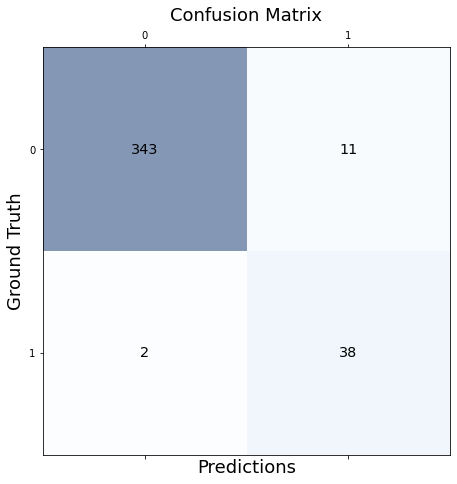

accuracy score 0.9670050761421319
f1 score 0.8539325842696629


In [ ]:
conf_matrix = confusion_matrix(val_labels_slic, np.concatenate(predictions_slic_val))
plot_confusion_matrix(conf_matrix)
print('accuracy score', accuracy_score(val_labels_slic, np.concatenate(predictions_slic_val)))
print('f1 score', f1_score(val_labels_slic, np.concatenate(predictions_slic_val)))

In [ ]:
#test set
prediction_maps = []
predictions_slic = []
for test_image in test_indices:
  prediction_map = np.zeros(segmented_images[test_image].shape).astype(np.uint8)
  num_regions = len(np.unique(segmented_images[test_image]))
  prediction_slic = classifier_rf_region.predict(eval("test_feat_" +str(test_image)))
  for region_id in range(num_regions):
    prediction_map[segmented_images[test_image]==region_id] = prediction_slic[region_id]
  prediction_maps.append(prediction_map) 
  predictions_slic.append(prediction_slic)

## With KNN 

In [ ]:
#search best hyper-parameters
reduction_values = [5,10,15,20,25,30,35,40,45,50,55,60,61] 
k_values = np.arange(1,42,1)
for r in tqdm_notebook(reduction_values):
  f1 = np.zeros(k_values.shape)
  accuracies = np.zeros(k_values.shape)
  pca_instance = PCA(r, random_state = 10)
  X_train_reduced_slic = pca_instance.fit_transform(norm_train_features_slic)
  X_val_reduced_slic = pca_instance.fit_transform(norm_val_features_slic)
  for ind,k in tqdm_notebook(enumerate(k_values)):
      classifier_knn_region = KNeighborsClassifier(n_neighbors=k)
      classifier_knn_region.fit(X_train_reduced_slic, train_labels_slic)
      prediction = classifier_knn_region.predict(X_val_reduced_slic)
      accuracies[ind] = accuracy_score(val_labels_slic, prediction)
      f1[ind] = f1_score(val_labels_slic, prediction)
  print("Best accuracy of %f with reduction to %d features and K=%d" % (accuracies.max(),r,np.argmax(accuracies))) 
  print("Best f1 of %f with reduction to %d features and K=%d" % (f1.max(),r,np.argmax(f1)))   

  0%|          | 0/13 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Best accuracy of 0.852792 with reduction to 5 features and K=29
Best f1 of 0.147059 with reduction to 5 features and K=29


0it [00:00, ?it/s]

Best accuracy of 0.857868 with reduction to 10 features and K=37
Best f1 of 0.151515 with reduction to 10 features and K=37


0it [00:00, ?it/s]

Best accuracy of 0.857868 with reduction to 15 features and K=20
Best f1 of 0.151515 with reduction to 15 features and K=20


0it [00:00, ?it/s]

Best accuracy of 0.857868 with reduction to 20 features and K=18
Best f1 of 0.151515 with reduction to 20 features and K=18


0it [00:00, ?it/s]

Best accuracy of 0.857868 with reduction to 25 features and K=18
Best f1 of 0.151515 with reduction to 25 features and K=18


0it [00:00, ?it/s]

Best accuracy of 0.860406 with reduction to 30 features and K=39
Best f1 of 0.153846 with reduction to 30 features and K=39


0it [00:00, ?it/s]

Best accuracy of 0.862944 with reduction to 35 features and K=39
Best f1 of 0.156250 with reduction to 35 features and K=39


0it [00:00, ?it/s]

Best accuracy of 0.862944 with reduction to 40 features and K=39
Best f1 of 0.156250 with reduction to 40 features and K=39


0it [00:00, ?it/s]

Best accuracy of 0.862944 with reduction to 45 features and K=39
Best f1 of 0.156250 with reduction to 45 features and K=39


0it [00:00, ?it/s]

Best accuracy of 0.862944 with reduction to 50 features and K=39
Best f1 of 0.156250 with reduction to 50 features and K=39


0it [00:00, ?it/s]

Best accuracy of 0.862944 with reduction to 55 features and K=39
Best f1 of 0.156250 with reduction to 55 features and K=39


0it [00:00, ?it/s]

Best accuracy of 0.862944 with reduction to 60 features and K=39
Best f1 of 0.156250 with reduction to 60 features and K=39


0it [00:00, ?it/s]

Best accuracy of 0.862944 with reduction to 61 features and K=39
Best f1 of 0.156250 with reduction to 61 features and K=39


In [ ]:
pca_instance_slic = PCA(35, random_state = 10)
X_train_reduced_slic = pca_instance_slic.fit_transform(norm_train_features_slic)
X_test_reduced_slic = pca_instance_slic.fit_transform(norm_test_features_slic)
X_val_reduced_slic = pca_instance_slic.fit_transform(norm_val_features_slic)

In [ ]:
classifier_knn_region = KNeighborsClassifier(n_neighbors=39)
classifier_knn_region.fit(X_train_reduced_slic, train_labels_slic)

KNeighborsClassifier(n_neighbors=39)

In [ ]:
pred_test_knn_slic = classifier_knn_region.predict(X_test_reduced_slic)
pred_val_knn_slic = classifier_knn_region.predict(X_val_reduced_slic)

Plot the confusion matrix of K Nearest Neighbors on regions on the validation set

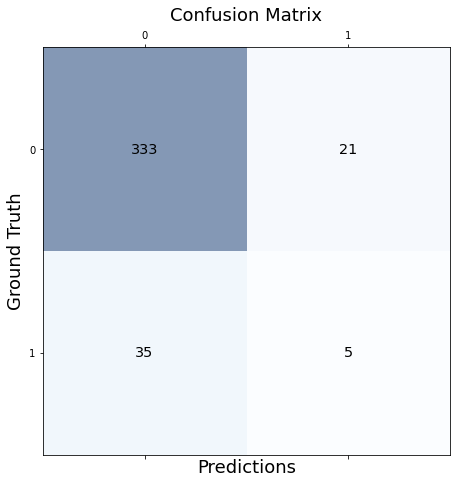

accuracy score 0.8578680203045685
f1 score 0.15151515151515152


In [ ]:
conf_matrix = confusion_matrix(val_labels_slic, pred_val_knn_slic)
plot_confusion_matrix(conf_matrix)
print('accuracy score', accuracy_score(val_labels_slic, pred_val_knn_slic))
print('f1 score', f1_score(val_labels_slic, pred_val_knn_slic))

In [ ]:
test_feat_slic_2 = pca_instance_slic.fit_transform(test_feat_2)
test_feat_slic_6 = pca_instance_slic.fit_transform(test_feat_6)
test_feat_slic_10 = pca_instance_slic.fit_transform(test_feat_10)

In [ ]:
prediction_maps_knn = []
predictions_slic_knn = []
for test_image in test_indices:
  prediction_map_knn = np.zeros(segmented_images[test_image].shape).astype(np.uint8)
  num_regions = len(np.unique(segmented_images[test_image]))
  prediction_slic_knn = classifier_knn_region.predict(eval("test_feat_slic_" +str(test_image)))
  for region_id in range(num_regions):
    prediction_map_knn[segmented_images[test_image]==region_id] = prediction_slic_knn[region_id]
  prediction_maps_knn.append(prediction_map_knn) 
  predictions_slic_knn.append(prediction_slic_knn)

# Comparision of different methods and visualization of snow in predicted years

The result of the confusion matrices have shown that the RF classifier works better than KNN, for both patches and slic. Then comparing patches and slic we can see that patches have the better result. 

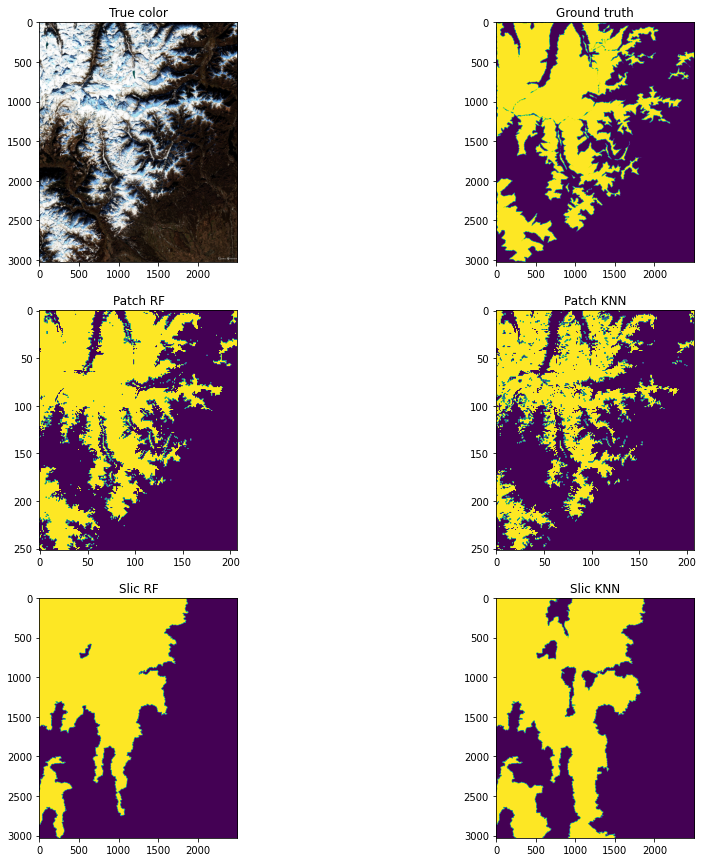

In [ ]:
#the original image, dec_2017
import matplotlib.image as mpimg
img = mpimg.imread('/content/drive/MyDrive/IPEO/06_December_2017_images/true_colour.jpg')
f, axs = plt.subplots(3,2,figsize=(15,15))
axs[0,0].imshow(img)
axs[0,0].title.set_text('True color')
#ground truth
axs[0,1].imshow(labels[2])
axs[0,1].title.set_text('Ground truth')
#predictions
axs[1,0].imshow(np.resize(pred_test_rf_patch[0:252*208],(252,208)))
axs[1,0].title.set_text('Patch RF')

axs[1,1].imshow(np.resize(pred_test_knn_patch[0:252*208],(252,208)))
axs[1,1].title.set_text('Patch KNN')

axs[2,0].imshow(prediction_maps[0])
axs[2,0].title.set_text('Slic RF')

axs[2,1].imshow(prediction_maps_knn[0])
axs[2,1].title.set_text('Slic KNN')

In [ ]:
index_2017 = int((len(pred_test_rf_patch)/3))
index_2019 = int((len(pred_test_rf_patch)/3)*2)
index_2021 = int((len(pred_test_rf_patch)/3)*3)

pred_2017 = pred_test_rf_patch[0:index_2017]
pred_2019 = pred_test_rf_patch[index_2017:index_2019]
pred_2021 = pred_test_rf_patch[index_2019:index_2021]

In [ ]:
snow = []
years = [pred_2017,pred_2019,pred_2021]
for year in years:
  snow.append(year.sum())

In [ ]:
snow_years = ["December_2017","December_2019","December_2021"]

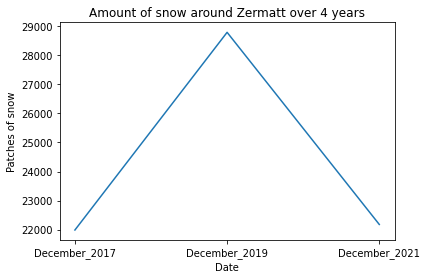

In [ ]:
plt.plot(snow_years,snow)
plt.xlabel('Date')
plt.ylabel('Patches of snow')
plt.title('Amount of snow around Zermatt over 4 years')
plt.show()